In [108]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import warnings
from matplotlib import pyplot as plt
import itertools
import glob, os
import statsmodels.api as sm
from numpy.polynomial.polynomial import polyfit

warnings.filterwarnings('ignore')

# Problem Statement:
- Which sectors contribute to a state's GDP?
- Does education dropout rate effect the GDP?

## PART I - Data Preprocessing

In [109]:
gdp_df = pd.read_csv('./datasets/GDP.csv')
gdp_df.head()

,Items Description,Duration,Andhra Pradesh,Arunachal Pradesh,Assam,Bihar,Chhattisgarh,Goa,Gujarat,Haryana,...,Telangana,Tripura,Uttar Pradesh,Uttarakhand,West Bengal1,Andaman & Nicobar Islands,Chandigarh,Delhi,Puducherry,All_India GDP
0,GSDP - CURRENT PRICES (` in Crore),2011-12,379402.0,11063.0,143175.0,247144.0,158074.0,42367.0,615606.0,297539.0,...,359433.0,19208.0,724049.0,115523.0,NaN,3979.0,18768.0,343767.0,16818.0,8736039.0
1,GSDP - CURRENT PRICES (` in Crore),2012-13,411404.0,12547.0,156864.0,282368.0,177511.0,38120.0,724495.0,347032.0,...,401493.0,21663.0,822903.0,131835.0,NaN,4421.0,21609.0,391238.0,18875.0,9946636.0
2,GSDP - CURRENT PRICES (` in Crore),2013-14,464272.0,14602.0,177745.0,317101.0,206690.0,35921.0,807623.0,400662.0,...,452186.0,25593.0,944146.0,149817.0,NaN,5159.0,24787.0,443783.0,21870.0,11236635.0
3,GSDP - CURRENT PRICES (` in Crore),2014-15,526468.0,16761.0,198098.0,373920.0,234982.0,40633.0,895027.0,437462.0,...,511178.0,29667.0,1043371.0,161985.0,NaN,5721.0,27844.0,492424.0,24089.0,12433749.0
4,GSDP - CURRENT PRICES (` in Crore),2015-16,609934.0,18784.0,224234.0,413503.0,260776.0,45002.0,994316.0,485184.0,...,575631.0,NaN,1153795.0,184091.0,NaN,NaN,30304.0,551963.0,26533.0,13675331.0


In [110]:
# We need to remove the additional spaces in the State names
gdp_df.columns = gdp_df.columns.str.strip()

In [111]:
union_territories = ["Andaman & Nicobar Islands", "Chandigarh", "Delhi", "Puducherry"]
gdp_df.drop(union_territories, axis = 1, inplace = True)

In [112]:
datacheck = pd.DataFrame(index = ["Missing Values"])
for column in gdp_df.columns:
    datacheck[column] = [gdp_df[column].isnull().sum().sum()] #This code sums all the NaN values for each of the columns 
maxMissingState = datacheck.idxmax(axis=1)[0]
gdp_df.drop([maxMissingState], axis = 1, inplace = True) 


In [113]:
pd.DataFrame([[gdp_df.shape],
            [gdp_df.isnull().sum().sum()],
             [gdp_df.duplicated().sum()]],
            columns = ['GDP data set'],
            index = ['Shape', 'Missingness', 'Duplicates'])

,GDP data set
Shape,"(11, 31)"
Missingness,56
Duplicates,0


In [114]:
duration_list=['2011-12','2012-13','2013-14','2014-15','2015-16', '2016-17']
for duration in duration_list:
    missing_val = gdp_df[gdp_df['Duration']==duration].isnull().sum().sum()
    print('Total missing values for duration {0}: {1}'.format(duration,missing_val))

Total missing values for duration 2011-12: 0
Total missing values for duration 2012-13: 0
Total missing values for duration 2013-14: 0
Total missing values for duration 2014-15: 0
Total missing values for duration 2015-16: 16
Total missing values for duration 2016-17: 40


In [115]:
gsdp_df = gdp_df[gdp_df['Items  Description'].str.contains('GSDP')]
gsdp_df.drop(columns=['Items  Description'],inplace=True)
gsdp_df

,Duration,Andhra Pradesh,Arunachal Pradesh,Assam,Bihar,Chhattisgarh,Goa,Gujarat,Haryana,Himachal Pradesh,...,Odisha,Punjab,Rajasthan,Sikkim,Tamil Nadu,Telangana,Tripura,Uttar Pradesh,Uttarakhand,All_India GDP
0,2011-12,379402.0,11063.0,143175.0,247144.0,158074.0,42367.0,615606.0,297539.0,72720.0,...,227872.0,266628.0,436465.0,11165.0,751485.0,359433.0,19208.0,724049.0,115523.0,8736039.0
1,2012-13,411404.0,12547.0,156864.0,282368.0,177511.0,38120.0,724495.0,347032.0,82820.0,...,258275.0,297734.0,494004.0,12338.0,855481.0,401493.0,21663.0,822903.0,131835.0,9946636.0
2,2013-14,464272.0,14602.0,177745.0,317101.0,206690.0,35921.0,807623.0,400662.0,94764.0,...,291709.0,334714.0,549701.0,13862.0,971090.0,452186.0,25593.0,944146.0,149817.0,11236635.0
3,2014-15,526468.0,16761.0,198098.0,373920.0,234982.0,40633.0,895027.0,437462.0,104369.0,...,321971.0,368011.0,612194.0,15209.0,1092564.0,511178.0,29667.0,1043371.0,161985.0,12433749.0
4,2015-16,609934.0,18784.0,224234.0,413503.0,260776.0,45002.0,994316.0,485184.0,NaN,...,341887.0,NaN,NaN,16637.0,1212668.0,575631.0,NaN,1153795.0,184091.0,13675331.0
5,2016-17,699307.0,NaN,NaN,NaN,290140.0,NaN,NaN,547396.0,NaN,...,378991.0,NaN,NaN,NaN,1338766.0,654294.0,NaN,NaN,NaN,15251028.0


In [116]:
growth_df = gdp_df[gdp_df['Items  Description'].str.contains('Growth')]
growth_df.drop(columns=['Items  Description'],inplace=True)
growth_df

,Duration,Andhra Pradesh,Arunachal Pradesh,Assam,Bihar,Chhattisgarh,Goa,Gujarat,Haryana,Himachal Pradesh,...,Odisha,Punjab,Rajasthan,Sikkim,Tamil Nadu,Telangana,Tripura,Uttar Pradesh,Uttarakhand,All_India GDP
6,2012-13,8.43,13.41,9.56,14.25,12.30,-10.02,17.69,16.63,13.89,...,13.34,11.67,13.18,10.51,13.84,11.70,12.78,13.65,14.12,13.86
7,2013-14,12.85,16.38,13.31,12.30,16.44,-5.77,11.47,15.45,14.42,...,12.95,12.42,11.27,12.35,13.51,12.63,18.14,14.73,13.64,12.97
8,2014-15,13.40,14.79,11.45,17.92,13.69,13.12,10.82,9.18,10.14,...,10.37,9.95,11.37,9.72,12.51,13.05,15.92,10.51,8.12,10.65
9,2015-16,15.85,12.07,13.19,10.59,10.98,10.75,11.09,10.91,NaN,...,6.19,NaN,NaN,9.39,10.99,12.61,NaN,10.58,13.65,9.99
10,2016-17,14.65,NaN,NaN,NaN,11.26,NaN,NaN,12.82,NaN,...,10.85,NaN,NaN,NaN,10.40,13.67,NaN,NaN,NaN,11.52


In [117]:
path = './datasets/states/*.csv'
all_files = glob.glob(path)
files_list=[]
states_datacheck = pd.DataFrame(index=['Missingness','Duplicates'])
states_data_list = []
gdp = []
for filename in all_files:
    
    #Retrieveing the state name from the filename
    state = filename.split("\\")[1].split(".")[0]
    stateL = state.split("_")
    state = " ".join(stateL)
    state_df = pd.read_csv(filename,index_col=None,header=0,encoding = 'unicode_escape')
    # We will be performing analysis for the years 2014-15
    gdp.append([state, list(state_df[state_df["Item"] == "Per Capita GSDP (Rs.)"][["2012-13", "2013-14", "2014-15"]].values)])
    state_df = state_df[['S.No.','Item', "2014-15"]]

    # print(state_df)
    
    # Generalising and simplifying the dataset by removing individual industries 
    state_df.drop(state_df.loc[state_df['S.No.'].isin(['1.1','1.2','1.3','1.4','6.1','6.2','7.1','7.2','7.3','7.4','7.5','7.6','7.7'])].index,inplace=True)
    # print(state_df)

    #Transpose the DataFrame
    state_df = state_df.T

    #take the row at index location1 and save it in header variable
    new_header = state_df.iloc[1]
    
    # select only the row with only relevant values by removing unwanted rows like S.No. etc
    state_df = state_df[2:]
    
    # set the columns of this dataframe using the header variable
    state_df.columns = new_header
    
    # Add new column as state name in dataframe
    state_df['State'] = state
    
    #reshuffle columns and bring State column in front
    col_list = list(state_df.columns)
    # print(col_list)
    col_list = col_list[-1:] + col_list[:-1]
    
    state_df = state_df[col_list]
    
    # Append the state's dataframe in the list
    states_data_list.append(state_df)

    # This piece of code will check for missingness and duplicates in each state dataframe
    states_datacheck[state]=[state_df.isnull().sum().sum(),state_df.duplicated().sum()]


# When all files are read and the data is available in final list
# then load that list in dataframe using concatenate function of pandas
all_states_df = pd.concat(states_data_list,axis=0,ignore_index=True)
all_states_df.head()

Item,State,"Agriculture, forestry and fishing",Mining and quarrying,Primary,Manufacturing,"Electricity, gas, water supply & other utility services",Construction,Secondary,"Trade, repair, hotels and restaurants","Transport, storage, communication & services related to broadcasting",...,"Real estate, ownership of dwelling & professional services",Public administration,Other services,Tertiary,TOTAL GSVA at basic prices,Taxes on Products,Subsidies on products,Gross State Domestic Product,Population ('00),Per Capita GSDP (Rs.)
0,Andhra Pradesh,14819416,1484300,16303716,4672266,1151729,4664889,10488884,4233400,5076984,...,4405409,2200897,4215389,22032942,48825542,5512100,1690800,52646842,501510,104977
1,Arunachal Pradesh,686117,30842,716959,26120,113527,147842,287489,60421,35203,...,48418,243867,218728,631844,1636292,70099,30272,1676119,14870,112718
2,Assam,3855548,1471149,5326697,2002936,296587,1733568,4033091,2987155,1194568,...,1412466,1373611,1795658,9307109,18666897,1725309,582406,19809800,326780,60621
3,Bihar,7951890,68107,8019997,2189965,345168,3449763,5984896,7448373,3147173,...,3740641,2078171,4587589,22179969,36184863,3213546,2006421,37391988,1101240,33954
4,Chandigarh,16233,179,16412,149631,29741,133321,312693,965781,148302,...,598448,183889,156543,2426008,2755113,52622,23309,2784426,11120,250398


In [118]:
all_states_df.drop(all_states_df.loc[all_states_df['State'].isin(["Andaman & Nicobar Islands", "Chandigarh", "Delhi", "Puducherry"])].index,inplace=True)
all_states_df.sort_values(by='Per Capita GSDP (Rs.)',ascending=False)

Item,State,"Agriculture, forestry and fishing",Mining and quarrying,Primary,Manufacturing,"Electricity, gas, water supply & other utility services",Construction,Secondary,"Trade, repair, hotels and restaurants","Transport, storage, communication & services related to broadcasting",...,"Real estate, ownership of dwelling & professional services",Public administration,Other services,Tertiary,TOTAL GSVA at basic prices,Taxes on Products,Subsidies on products,Gross State Domestic Product,Population ('00),Per Capita GSDP (Rs.)
7,Goa,308507,3622,312129,1177608,204110,165819,1547536,380927,189656,...,407099,346486,180431,1738217,3597882,527279,61854,4063307,14950,271793
24,Sikkim,137447,1329,138776,550697,212499,82058,845253,70568,47347,...,75330,119514,149265,483103,1467133,72200,18400,1520933,6330,240274
9,Haryana,8015238.0,25186.0,8040424.0,7756921.0,1101919.0,3702571.0,12561411.0,4986319.0,2560623.0,...,6970183.0,1036377.0,2001581.0,19226568.0,39828404.0,4985670.0,1067867.0,43746207.0,266620.0,164077.0
14,Kerala,5930617,558824,6489442,4273567,482470,7314003,12070040,8557345,4020934,...,7287633,2068915,5728645,29673778,48233259,5189352,822381,52600230,339843,154778
28,Uttarakhand,1601423.0,244549.0,1845972.0,5866252.0,433880.0,1342733.0,7642865.0,1743106.0,1066693.0,...,831307.0,579409.0,982430.0,5587975.0,15076812.0,1434856.0,313139.0,16198529.0,105820.0,153076.0
16,Maharashtra,16475655,5282727,21758383,33660294,4334702,9450211,47445207,15839100,9697246,...,30718051,5426991,10806363,88631076,157834665,25394800,4017300,179212165,1172450,152853
10,Himachal Pradesh,1514981,33385,1548366,2543637,767268,808256,4119162,615496,552234,...,1125937,553974,923164,4133326,9800853,895317,259291,10436879,70840,147330
25,Tamil Nadu,13064238,265536,13329774,18914794,1710379,12216718,32841892,12895842,7188320,...,16830213,3400800,7430115,53343788,99515453,12507325,2766405,109256373,745760,146503
13,Karnataka,11219422,846882,12066304,12953843,1425762,6104799,20484404,8991658,5097652,...,24766393,2232584,5308174,50490630,83041338,11026674,1889206,92178806,635100,145141
8,Gujarat,13769969.0,2117218.0,15887187.0,24087538.0,3409983.0,5526017.0,33023538.0,10178713.0,4555910.0,...,5179502.0,2576195.0,3123413.0,30220377.0,79131102.0,12353171.04,1981546.0,89502727.0,633590.0,141263.0


In [119]:
all_states_df['Primary_Perc'] = ((all_states_df['Primary']/all_states_df['Gross State Domestic Product'])*100).astype(float).round(2)
all_states_df['Secondary_Perc'] = ((all_states_df['Secondary']/all_states_df['Gross State Domestic Product'])*100).astype(float).round(2)
all_states_df['Tertiary_Perc'] = ((all_states_df['Tertiary']/all_states_df['Gross State Domestic Product'])*100).astype(float).round(2)
all_states_df['Taxes_Perc'] = ((all_states_df['Taxes on Products']/all_states_df['Gross State Domestic Product'])*100).astype(float).round(2)
all_states_df['Subsidies_Perc'] = ((all_states_df['Subsidies on products']/all_states_df['Gross State Domestic Product'])*100).astype(float).round(2)
all_states_df['AllSectors_Perc'] = all_states_df['Primary_Perc'] + all_states_df['Secondary_Perc'] + all_states_df['Tertiary_Perc']
all_states_df.head()

Item,State,"Agriculture, forestry and fishing",Mining and quarrying,Primary,Manufacturing,"Electricity, gas, water supply & other utility services",Construction,Secondary,"Trade, repair, hotels and restaurants","Transport, storage, communication & services related to broadcasting",...,Subsidies on products,Gross State Domestic Product,Population ('00),Per Capita GSDP (Rs.),Primary_Perc,Secondary_Perc,Tertiary_Perc,Taxes_Perc,Subsidies_Perc,AllSectors_Perc
0,Andhra Pradesh,14819416,1484300,16303716,4672266,1151729,4664889,10488884,4233400,5076984,...,1690800,52646842,501510,104977,30.97,19.92,41.85,10.47,3.21,92.74
1,Arunachal Pradesh,686117,30842,716959,26120,113527,147842,287489,60421,35203,...,30272,1676119,14870,112718,42.77,17.15,37.70,4.18,1.81,97.62
2,Assam,3855548,1471149,5326697,2002936,296587,1733568,4033091,2987155,1194568,...,582406,19809800,326780,60621,26.89,20.36,46.98,8.71,2.94,94.23
3,Bihar,7951890,68107,8019997,2189965,345168,3449763,5984896,7448373,3147173,...,2006421,37391988,1101240,33954,21.45,16.01,59.32,8.59,5.37,96.78
5,Chattisgarh,3948847,2451970,6400817,4370593,1198438,2669855,8238886,1535571,871770,...,1332092,23498180,270530,86860,27.24,35.06,32.30,11.07,5.67,94.60


In [120]:
all_states_df['Percentile_Rank'] = round(all_states_df['Gross State Domestic Product'].rank(pct=True),2)
all_states_df.head()

Item,State,"Agriculture, forestry and fishing",Mining and quarrying,Primary,Manufacturing,"Electricity, gas, water supply & other utility services",Construction,Secondary,"Trade, repair, hotels and restaurants","Transport, storage, communication & services related to broadcasting",...,Gross State Domestic Product,Population ('00),Per Capita GSDP (Rs.),Primary_Perc,Secondary_Perc,Tertiary_Perc,Taxes_Perc,Subsidies_Perc,AllSectors_Perc,Percentile_Rank
0,Andhra Pradesh,14819416,1484300,16303716,4672266,1151729,4664889,10488884,4233400,5076984,...,52646842,501510,104977,30.97,19.92,41.85,10.47,3.21,92.74,0.79
1,Arunachal Pradesh,686117,30842,716959,26120,113527,147842,287489,60421,35203,...,1676119,14870,112718,42.77,17.15,37.70,4.18,1.81,97.62,0.11
2,Assam,3855548,1471149,5326697,2002936,296587,1733568,4033091,2987155,1194568,...,19809800,326780,60621,26.89,20.36,46.98,8.71,2.94,94.23,0.43
3,Bihar,7951890,68107,8019997,2189965,345168,3449763,5984896,7448373,3147173,...,37391988,1101240,33954,21.45,16.01,59.32,8.59,5.37,96.78,0.61
5,Chattisgarh,3948847,2451970,6400817,4370593,1198438,2669855,8238886,1535571,871770,...,23498180,270530,86860,27.24,35.06,32.30,11.07,5.67,94.60,0.50


In [121]:
dropout_df = pd.read_csv('./datasets/rop-Out_Rate_from_2012-13_to_2014-15.csv')
dropout_df.head()

,Sl. No.,Level of Education - State,Primary - 2012-2013,Primary - 2014-2015,Primary - 2014-2015.1,Upper Primary - 2012-2013,Upper Primary - 2013-2014,Upper Primary - 2014-2015,Secondary - 2012-2013,Secondary - 2013-2014,Secondary - 2014-2015,Senior Secondary - 2012-2013,Senior Secondary - 2013-2014,Senior Secondary - 2014-2015
0,1,A & N Islands,0.68,1.21,0.51,1.23,0.51,1.69,5.56,7.20,9.87,14.14,15.87,16.93
1,2,Andhra Pradesh,3.18,4.35,6.72,3.36,3.78,5.20,12.72,12.65,15.71,0.35,11.79,NaN
2,3,Arunachal Pradesh,15.16,10.89,10.82,7.47,5.59,6.71,12.93,14.49,17.11,5.11,17.07,18.42
3,4,Assam,6.24,7.44,15.36,7.20,7.05,10.51,26.77,30.43,27.06,4.69,7.24,NaN
4,5,Bihar,NaN,2.09,NaN,NaN,2.98,4.08,30.14,25.33,25.90,NaN,NaN,NaN


In [122]:
dropout_df.drop(dropout_df.loc[dropout_df['Level of Education - State'].isin(['A & N Islands','Chandigarh','Dadra & Nagar Haveli', 'Daman & Diu','Delhi','Lakshadweep','Puducherry'])].index,inplace=True)
dropout_df.drop(dropout_df.loc[dropout_df['Level of Education - State'].isin(['West Bengal'])].index,inplace=True)
dropout_df.columns

Index(['Sl. No.', 'Level of Education - State', 'Primary - 2012-2013',
       'Primary - 2014-2015', 'Primary - 2014-2015.1',
       'Upper Primary - 2012-2013', 'Upper Primary - 2013-2014',
       'Upper Primary - 2014-2015', 'Secondary - 2012-2013',
       'Secondary - 2013-2014', 'Secondary - 2014-2015',
       'Senior Secondary - 2012-2013', 'Senior Secondary - 2013-2014',
       'Senior Secondary - 2014-2015'],
      dtype='object')

In [123]:
dropout_df["Primary - 2013-2014"] = dropout_df['Primary - 2014-2015']
dropout_df["Primary - 2014-2015"] = dropout_df['Primary - 2014-2015.1']
education = dropout_df[['Level of Education - State','Primary - 2012-2013', 'Primary - 2013-2014', 'Primary - 2014-2015']]
dropout_df = dropout_df[['Level of Education - State','Primary - 2014-2015','Upper Primary - 2014-2015','Secondary - 2014-2015']]

In [124]:
dropout_df.rename(columns={'Level of Education - State':'State'},inplace=True)
dropout_df

,State,Primary - 2014-2015,Upper Primary - 2014-2015,Secondary - 2014-2015
1,Andhra Pradesh,6.72,5.20,15.71
2,Arunachal Pradesh,10.82,6.71,17.11
3,Assam,15.36,10.51,27.06
4,Bihar,NaN,4.08,25.90
6,Chhatisgarh,2.91,5.85,21.26
10,Goa,0.73,0.07,11.15
11,Gujarat,0.89,6.41,25.04
12,Haryana,5.61,5.81,15.89
13,Himachal Pradesh,0.64,0.87,6.07
14,Jammu and Kashmir,6.79,5.44,17.28


In [125]:
state_category_df = all_states_df.copy()
category_labels = ['C4', 'C3', 'C2', 'C1']
state_category_df['Category'] = pd.qcut(state_category_df['Per Capita GSDP (Rs.)'],q=[0, 0.25, .5, .75, 1],labels=category_labels)
state_category_df

Item,State,"Agriculture, forestry and fishing",Mining and quarrying,Primary,Manufacturing,"Electricity, gas, water supply & other utility services",Construction,Secondary,"Trade, repair, hotels and restaurants","Transport, storage, communication & services related to broadcasting",...,Population ('00),Per Capita GSDP (Rs.),Primary_Perc,Secondary_Perc,Tertiary_Perc,Taxes_Perc,Subsidies_Perc,AllSectors_Perc,Percentile_Rank,Category
0,Andhra Pradesh,14819416,1484300,16303716,4672266,1151729,4664889,10488884,4233400,5076984,...,501510,104977,30.97,19.92,41.85,10.47,3.21,92.74,0.79,C2
1,Arunachal Pradesh,686117,30842,716959,26120,113527,147842,287489,60421,35203,...,14870,112718,42.77,17.15,37.70,4.18,1.81,97.62,0.11,C2
2,Assam,3855548,1471149,5326697,2002936,296587,1733568,4033091,2987155,1194568,...,326780,60621,26.89,20.36,46.98,8.71,2.94,94.23,0.43,C4
3,Bihar,7951890,68107,8019997,2189965,345168,3449763,5984896,7448373,3147173,...,1101240,33954,21.45,16.01,59.32,8.59,5.37,96.78,0.61,C4
5,Chattisgarh,3948847,2451970,6400817,4370593,1198438,2669855,8238886,1535571,871770,...,270530,86860,27.24,35.06,32.30,11.07,5.67,94.60,0.50,C3
7,Goa,308507,3622,312129,1177608,204110,165819,1547536,380927,189656,...,14950,271793,7.68,38.09,42.78,12.98,1.52,88.55,0.29,C1
8,Gujarat,13769969.0,2117218.0,15887187.0,24087538.0,3409983.0,5526017.0,33023538.0,10178713.0,4555910.0,...,633590.0,141263.0,17.75,36.90,33.76,13.80,2.21,88.41,0.86,C2
9,Haryana,8015238.0,25186.0,8040424.0,7756921.0,1101919.0,3702571.0,12561411.0,4986319.0,2560623.0,...,266620.0,164077.0,18.38,28.71,43.95,11.40,2.44,91.04,0.64,C1
10,Himachal Pradesh,1514981,33385,1548366,2543637,767268,808256,4119162,615496,552234,...,70840,147330,14.84,39.47,39.60,8.58,2.48,93.91,0.36,C1
11,Jammu Kashmir,1586705,33621,1620326,893207,597421,785503,2276132,889931,712552,...,132390,75840,16.14,22.67,55.91,7.61,2.33,94.72,0.32,C3


In [126]:
state_category_states =  list(state_category_df['State'])
dropout_states = list(dropout_df['State'])
state_intersection = set(state_category_states)-set(dropout_states)
state_intersection

{'Chattisgarh', 'Jammu Kashmir', 'Jharkand', 'Telenghana', 'Uttarakhand'}

In [127]:
dropout_intersection = set(dropout_states)-set(state_category_states)
dropout_intersection

{'All India',
 'Chhatisgarh',
 'Jammu and Kashmir',
 'Jharkhand',
 'Telangana',
 'Uttrakhand'}

In [128]:
dropout_intersection.remove('All India')
dropout_intersection

{'Chhatisgarh', 'Jammu and Kashmir', 'Jharkhand', 'Telangana', 'Uttrakhand'}

In [129]:
state_intersection = list(state_intersection)
for i,dropout_state in enumerate(dropout_intersection):
#     print(i, dropout_state)
    dropout_df.loc[dropout_df.loc[dropout_df['State']==dropout_state].index[0],'State']=state_intersection[i]
dropout_df

,State,Primary - 2014-2015,Upper Primary - 2014-2015,Secondary - 2014-2015
1,Andhra Pradesh,6.72,5.20,15.71
2,Arunachal Pradesh,10.82,6.71,17.11
3,Assam,15.36,10.51,27.06
4,Bihar,NaN,4.08,25.90
6,Jammu Kashmir,2.91,5.85,21.26
10,Goa,0.73,0.07,11.15
11,Gujarat,0.89,6.41,25.04
12,Haryana,5.61,5.81,15.89
13,Himachal Pradesh,0.64,0.87,6.07
14,Chattisgarh,6.79,5.44,17.28


In [130]:
state_category_states =  list(state_category_df['State'])
dropout_states = list(dropout_df['State'])
state_intersection = set(state_category_states)-set(dropout_states)
print(state_intersection)
dropout_intersection = set(dropout_states)-set(state_category_states)
print(dropout_intersection)

set()
{'All India'}


In [131]:
print('shape of state category df before merge: {0}'.format(state_category_df.shape))
print('shape of dropout df before merge: {0}'.format(dropout_df.shape))
state_dropout_df = pd.merge(state_category_df,dropout_df,on='State',how='left')
print('shape of new df after merge: {0}'.format(state_dropout_df.shape))
state_dropout_df

shape of state category df before merge: (28, 29)
shape of dropout df before merge: (29, 4)
shape of new df after merge: (28, 32)


,State,"Agriculture, forestry and fishing",Mining and quarrying,Primary,Manufacturing,"Electricity, gas, water supply & other utility services",Construction,Secondary,"Trade, repair, hotels and restaurants","Transport, storage, communication & services related to broadcasting",...,Secondary_Perc,Tertiary_Perc,Taxes_Perc,Subsidies_Perc,AllSectors_Perc,Percentile_Rank,Category,Primary - 2014-2015,Upper Primary - 2014-2015,Secondary - 2014-2015
0,Andhra Pradesh,14819416,1484300,16303716,4672266,1151729,4664889,10488884,4233400,5076984,...,19.92,41.85,10.47,3.21,92.74,0.79,C2,6.72,5.20,15.71
1,Arunachal Pradesh,686117,30842,716959,26120,113527,147842,287489,60421,35203,...,17.15,37.70,4.18,1.81,97.62,0.11,C2,10.82,6.71,17.11
2,Assam,3855548,1471149,5326697,2002936,296587,1733568,4033091,2987155,1194568,...,20.36,46.98,8.71,2.94,94.23,0.43,C4,15.36,10.51,27.06
3,Bihar,7951890,68107,8019997,2189965,345168,3449763,5984896,7448373,3147173,...,16.01,59.32,8.59,5.37,96.78,0.61,C4,NaN,4.08,25.90
4,Chattisgarh,3948847,2451970,6400817,4370593,1198438,2669855,8238886,1535571,871770,...,35.06,32.30,11.07,5.67,94.60,0.50,C3,6.79,5.44,17.28
5,Goa,308507,3622,312129,1177608,204110,165819,1547536,380927,189656,...,38.09,42.78,12.98,1.52,88.55,0.29,C1,0.73,0.07,11.15
6,Gujarat,13769969.0,2117218.0,15887187.0,24087538.0,3409983.0,5526017.0,33023538.0,10178713.0,4555910.0,...,36.90,33.76,13.80,2.21,88.41,0.86,C2,0.89,6.41,25.04
7,Haryana,8015238.0,25186.0,8040424.0,7756921.0,1101919.0,3702571.0,12561411.0,4986319.0,2560623.0,...,28.71,43.95,11.40,2.44,91.04,0.64,C1,5.61,5.81,15.89
8,Himachal Pradesh,1514981,33385,1548366,2543637,767268,808256,4119162,615496,552234,...,39.47,39.60,8.58,2.48,93.91,0.36,C1,0.64,0.87,6.07
9,Jammu Kashmir,1586705,33621,1620326,893207,597421,785503,2276132,889931,712552,...,22.67,55.91,7.61,2.33,94.72,0.32,C3,2.91,5.85,21.26


## PART II - Summary Statistics

In [132]:
temp = state_category_df.copy()
temp = temp["Per Capita GSDP (Rs.)"]
temp

0       104977
1       112718
2        60621
3        33954
5        86860
7       271793
8     141263.0
9     164077.0
10      147330
11       75840
12       62091
13      145141
14      154778
15       62989
16      152853
17     58442.0
18     76228.0
19       97687
20       89607
21       73979
22      126606
23       84837
24      240274
25      146503
26      139035
27     77358.0
28    153076.0
29       49450
Name: Per Capita GSDP (Rs.), dtype: object

In [133]:
temp.describe()

count         28.0
unique        28.0
top       104977.0
freq           1.0
Name: Per Capita GSDP (Rs.), dtype: float64

In [134]:
temp.mean()

113941.67857142857

In [135]:
temp.median()

101332.0

33954 271793


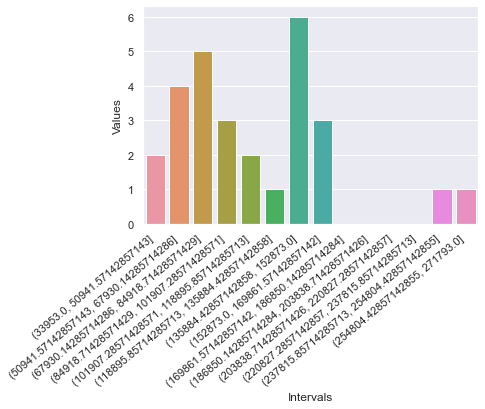

In [136]:
m = temp.min()
M = temp.max()
interval = M - m
print(m, M)
temp = temp.groupby(pd.cut(temp, pd.interval_range(m-1, M, 14))).count()
df = pd.DataFrame(temp)
df.columns = ["Values"]
temp_df = pd.DataFrame([df.index, df["Values"]])
temp_df = temp_df.T
temp_df.columns=["Intervals", "Values"]

# plt.figure(figsize=(25, 25))
ax = sns.barplot(x = temp_df["Intervals"], y=temp_df["Values"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

In [137]:
temp = dropout_df.copy()
temp.drop("State",axis=1, inplace=True)
temp

,Primary - 2014-2015,Upper Primary - 2014-2015,Secondary - 2014-2015
1,6.72,5.20,15.71
2,10.82,6.71,17.11
3,15.36,10.51,27.06
4,NaN,4.08,25.90
6,2.91,5.85,21.26
10,0.73,0.07,11.15
11,0.89,6.41,25.04
12,5.61,5.81,15.89
13,0.64,0.87,6.07
14,6.79,5.44,17.28


In [138]:
temp.describe()

,Primary - 2014-2015,Upper Primary - 2014-2015,Secondary - 2014-2015
count,26.000000,27.000000,29.000000
mean,5.152308,4.521481,17.763448
std,3.752050,2.680367,6.598473
min,0.640000,0.070000,6.070000
25%,2.127500,2.500000,12.870000
50%,4.575000,4.080000,17.060000
75%,6.772500,6.130000,24.000000
max,15.360000,10.510000,29.560000


In [139]:
temp.mean()

Primary - 2014-2015           5.152308
Upper Primary - 2014-2015     4.521481
Secondary - 2014-2015        17.763448
dtype: float64

In [140]:
temp.median()

Primary - 2014-2015           4.575
Upper Primary - 2014-2015     4.080
Secondary - 2014-2015        17.060
dtype: float64

0.64 15.36


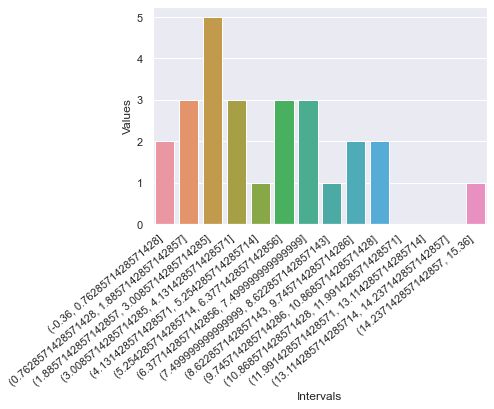

0.07 10.51


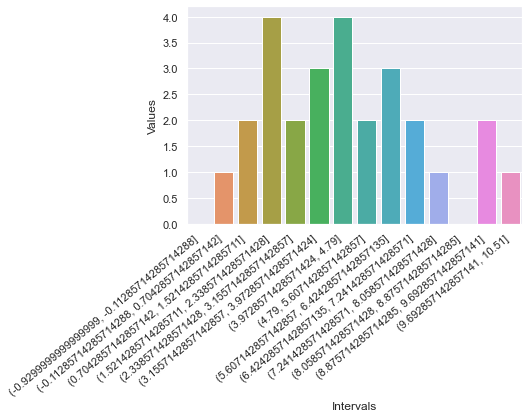

6.07 29.56


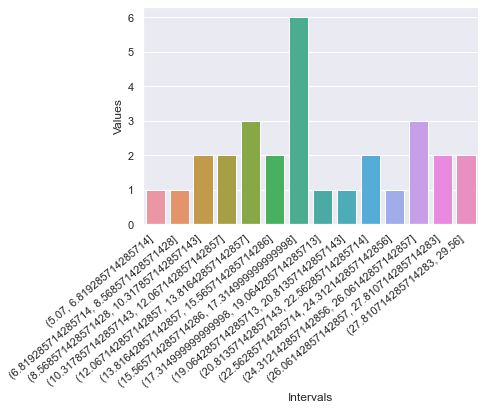

In [141]:
for col in temp.columns:
    m = temp[col].min()
    M = temp[col].max()
    interval = M - m
    print(m, M)
    df = temp[col].groupby(pd.cut(temp[col], pd.interval_range(m-1, M, 14))).count()
    df = pd.DataFrame(df)
    df.columns = ["Values"]
    temp_df = pd.DataFrame([df.index, df["Values"]])
    temp_df = temp_df.T
    temp_df.columns=["Intervals", "Values"]

    # plt.figure(figsize=(25, 25))
    ax = sns.barplot(x = temp_df["Intervals"], y=temp_df["Values"])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.show()

## Plotting Bar and Line plots of the GSDP Data

In [142]:
#Plots seaborn barlot
plt.style.use('seaborn-white')

def subplot_barplot(dataframe, columns, target):
    sns.set(font_scale=1)
    nrows = int(np.ceil(len(columns)/2)) 
    
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(15, len(columns)*3), sharex=False, sharey=False)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate

    # print(ax)

    for i, state in enumerate(columns): # Gives us an index value to get into all our lists
        sns.barplot(x = dataframe[state], y = dataframe[target], data = dataframe, ax=ax[i])
        ax[i].set_title('% Growth over previous year for State {0}'.format(columns[i]))
        ax[i].set_xlabel('Percentage') 
        ax[i].set_ylabel(target)

In [143]:

#Plots seaborn linelot
plt.style.use('seaborn-white')

def subplot_lineplot(dataframe, nation_growth_df, states, target):
    sns.set(font_scale=1)
    nrows = int(np.ceil(len(states)/2)) 

    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(15, len(states)*3), sharex=False, sharey=False)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    
    dataframe['Duration_num'] = dataframe[target].map({'2012-13' : 1, '2013-14' : 2, '2014-15' : 3, '2015-16' : 4, '2016-17':5})
    nation_growth_df['Duration_num'] = nation_growth_df[target].map({'2012-13' : 1, '2013-14' : 2, '2014-15' : 3, '2015-16' : 4, '2016-17':5})
    
    df_slope = pd.DataFrame(columns=['State','Slope'])
    for i, state in enumerate(states):

        x=dataframe['Duration_num']
        y=dataframe[state]
        idx = np.isfinite(x) & np.isfinite(y)
        m,c = np.polyfit(x[idx], y[idx], 1)
        
        row = [states[i],m]
        df_slope.loc[i] = row
        
        
        sns.scatterplot(x='Duration_num',y=state,data = dataframe, markers='x',ax=ax[i], label='{0} Growth%'.format(states[i]))
        sns.lineplot(x,m*x+c,ax=ax[i],label='{0} Growth%'.format(states[i]),markers='o')
        
        x_nation=nation_growth_df['Duration_num']
        y_nation=nation_growth_df['All_India GDP'].fillna(0)
        m_nation,c_nation = np.polyfit(x_nation,y_nation,deg=1) 
        sns.scatterplot(x='Duration_num',y='All_India GDP',data = nation_growth_df, markers='x',ax=ax[i], label='All India Growth%')
        sns.lineplot(x_nation,m_nation*x_nation+c_nation,ax=ax[i], label='All India Growth%',markers='o')
        
        ax[i].set_title('% Growth over previous year for State {0}'.format(states[i]),color='blue')
        ax[i].set_ylabel('Percentage') 
        ax[i].set_xlabel(target)
        ax[i].set_xticklabels(size=10, labels=[' ','2012-13',' ','2013-14',' ','2014-15',' ','2015-16', ' ', '2016-17'])
        
    return df_slope

In [144]:
#Selecting only state columns and creating a new dataframe
col_list=[col for col in growth_df if col!='All_India GDP']
state_list = [col for col in col_list if col!='Duration']

growth_state_df = growth_df[col_list]

In [145]:
growth_state_df

,Duration,Andhra Pradesh,Arunachal Pradesh,Assam,Bihar,Chhattisgarh,Goa,Gujarat,Haryana,Himachal Pradesh,...,Nagaland,Odisha,Punjab,Rajasthan,Sikkim,Tamil Nadu,Telangana,Tripura,Uttar Pradesh,Uttarakhand
6,2012-13,8.43,13.41,9.56,14.25,12.30,-10.02,17.69,16.63,13.89,...,15.03,13.34,11.67,13.18,10.51,13.84,11.70,12.78,13.65,14.12
7,2013-14,12.85,16.38,13.31,12.30,16.44,-5.77,11.47,15.45,14.42,...,21.98,12.95,12.42,11.27,12.35,13.51,12.63,18.14,14.73,13.64
8,2014-15,13.40,14.79,11.45,17.92,13.69,13.12,10.82,9.18,10.14,...,10.85,10.37,9.95,11.37,9.72,12.51,13.05,15.92,10.51,8.12
9,2015-16,15.85,12.07,13.19,10.59,10.98,10.75,11.09,10.91,NaN,...,NaN,6.19,NaN,NaN,9.39,10.99,12.61,NaN,10.58,13.65
10,2016-17,14.65,NaN,NaN,NaN,11.26,NaN,NaN,12.82,NaN,...,NaN,10.85,NaN,NaN,NaN,10.40,13.67,NaN,NaN,NaN


In [146]:
national_gdp_df=growth_df[['Duration','All_India GDP']]
national_gdp_df

,Duration,All_India GDP
6,2012-13,13.86
7,2013-14,12.97
8,2014-15,10.65
9,2015-16,9.99
10,2016-17,11.52


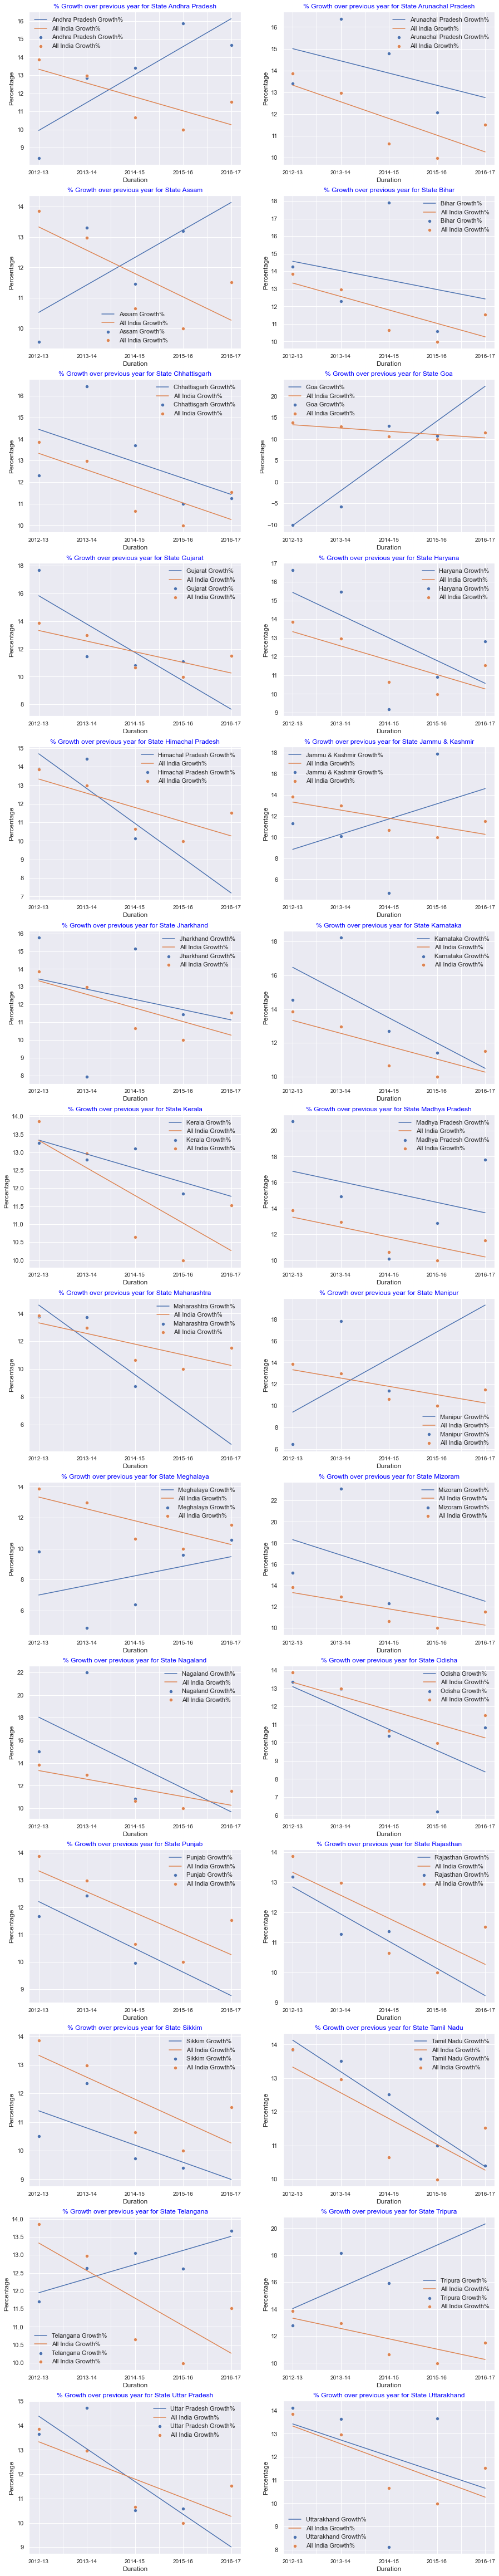

In [147]:
slope_df = subplot_lineplot(growth_state_df, national_gdp_df, state_list, 'Duration')

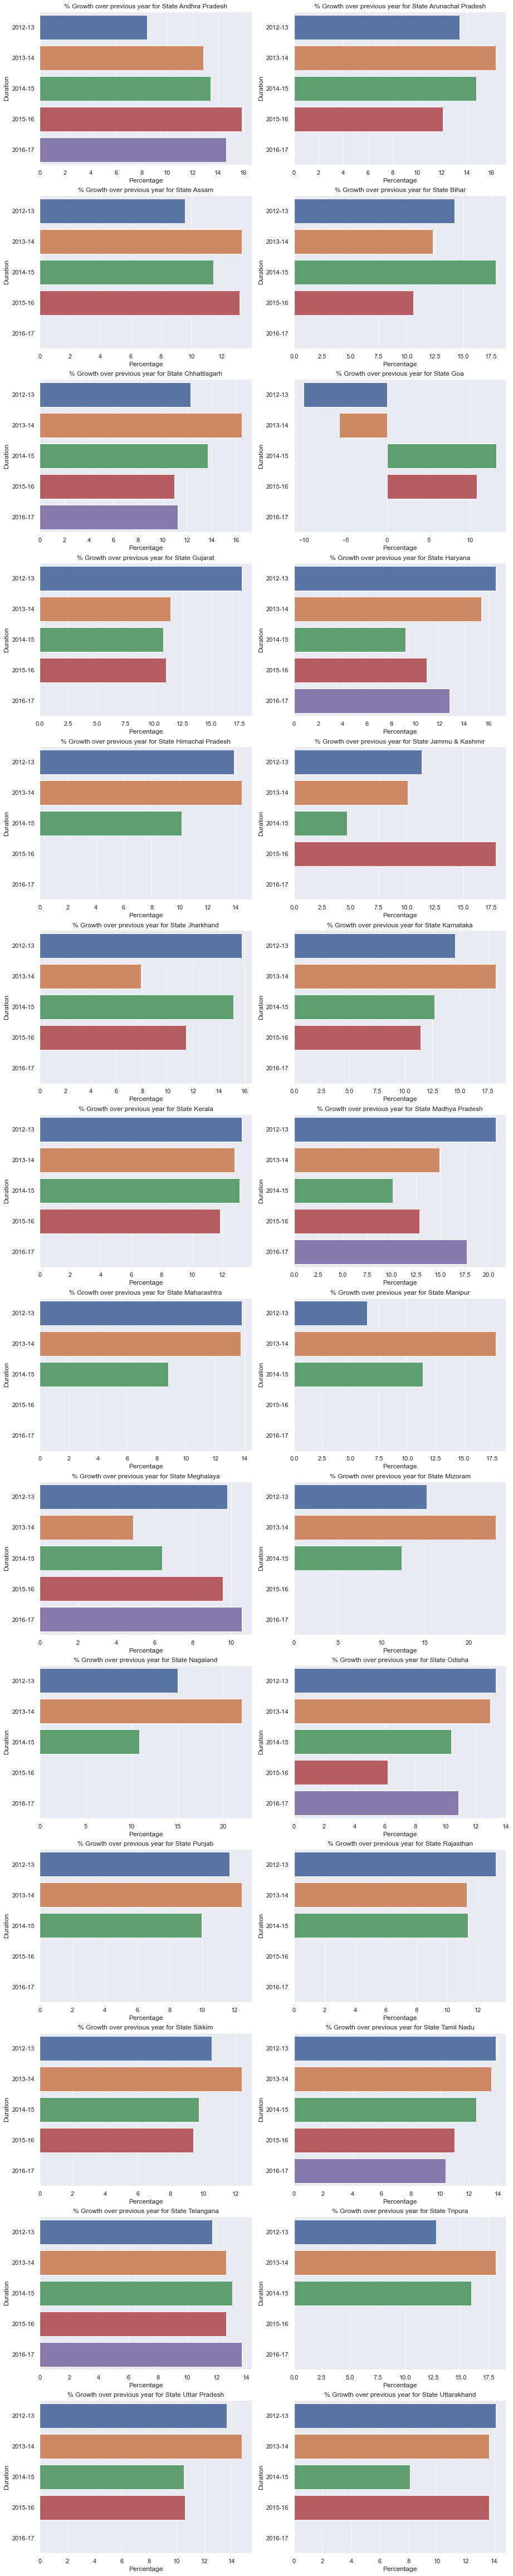

In [148]:
bar_df = subplot_barplot(growth_state_df, state_list, 'Duration')

In [149]:
slope_df.sort_values(by='Slope',ascending=False)

,State,Slope
5,Goa,8.120
15,Manipur,2.470
25,Tripura,1.570
0,Andhra Pradesh,1.544
9,Jammu & Kashmir,1.441
2,Assam,0.903
16,Meghalaya,0.619
24,Telangana,0.392
12,Kerala,-0.391
3,Bihar,-0.536


# Observations from above Plot:
- There is a negtaive trend in %growth of GDP of India as can be seen from above plot. The %growth of nation is continuously decreasing from yr 2012-13 till 2016-17
 - Andhra Pradesh, Assam, Goa, Jammu & Kashmir, Manipur, Telangana, Tripura, Meghalaya states have continuos trend of increase in %growth over previous years.
 - Out of these Goa has the highest value of positive slope. This means Goa state has continuous trend of increase in %growth of GDP
 - Goa, Manipur, Andhra Pradesh have the highest trend of continous increase in %growth of state GDP
 - Despite India’s average growth being negative, the above states have been growing at an unprecedented range. This could be possible due to multiple factors – low base non-dependence on external factors etc.
 - Madhya Pradesh, Maharashtra, Odisha are the 3 states with continuous low performing trend wrt %growth of state GDP
 - India’s one of largest state Maharashtra has been de-growing more than India’s national average. Other states like Gujarat, Karnataka are also showing negative growth. Mizoram has been de-growing but still not at par with national average (perhaps base effect)

## Plotting the average growth of each state over the years

In [150]:
growth_transpose_df= growth_df.T
growth_transpose_df.rename(columns={6:'2012-13', 7:'2013-14',8:'2014-15',9:'2015-16', 10:'2016-17'},inplace=True)
growth_transpose_df = growth_transpose_df[1:]
growth_transpose_df

,2012-13,2013-14,2014-15,2015-16,2016-17
Andhra Pradesh,8.43,12.85,13.4,15.85,14.65
Arunachal Pradesh,13.41,16.38,14.79,12.07,NaN
Assam,9.56,13.31,11.45,13.19,NaN
Bihar,14.25,12.3,17.92,10.59,NaN
Chhattisgarh,12.3,16.44,13.69,10.98,11.26
Goa,-10.02,-5.77,13.12,10.75,NaN
Gujarat,17.69,11.47,10.82,11.09,NaN
Haryana,16.63,15.45,9.18,10.91,12.82
Himachal Pradesh,13.89,14.42,10.14,NaN,NaN
Jammu & Kashmir,11.31,10.09,4.7,17.91,NaN


In [151]:
growth_transpose_df['Average_Growth'] = round(growth_transpose_df.mean(axis=1),2)
growth_transpose_df.sort_values(by='Average_Growth',ascending=False)

,2012-13,2013-14,2014-15,2015-16,2016-17,Average_Growth
Mizoram,15.2,23.1,12.3,NaN,NaN,16.87
Nagaland,15.03,21.98,10.85,NaN,NaN,15.95
Tripura,12.78,18.14,15.92,NaN,NaN,15.61
Madhya Pradesh,20.71,14.91,10.11,12.86,17.74,15.27
Karnataka,14.56,18.24,12.7,11.42,NaN,14.23
Arunachal Pradesh,13.41,16.38,14.79,12.07,NaN,14.16
Bihar,14.25,12.3,17.92,10.59,NaN,13.76
Andhra Pradesh,8.43,12.85,13.4,15.85,14.65,13.04
Haryana,16.63,15.45,9.18,10.91,12.82,13.00
Chhattisgarh,12.3,16.44,13.69,10.98,11.26,12.93


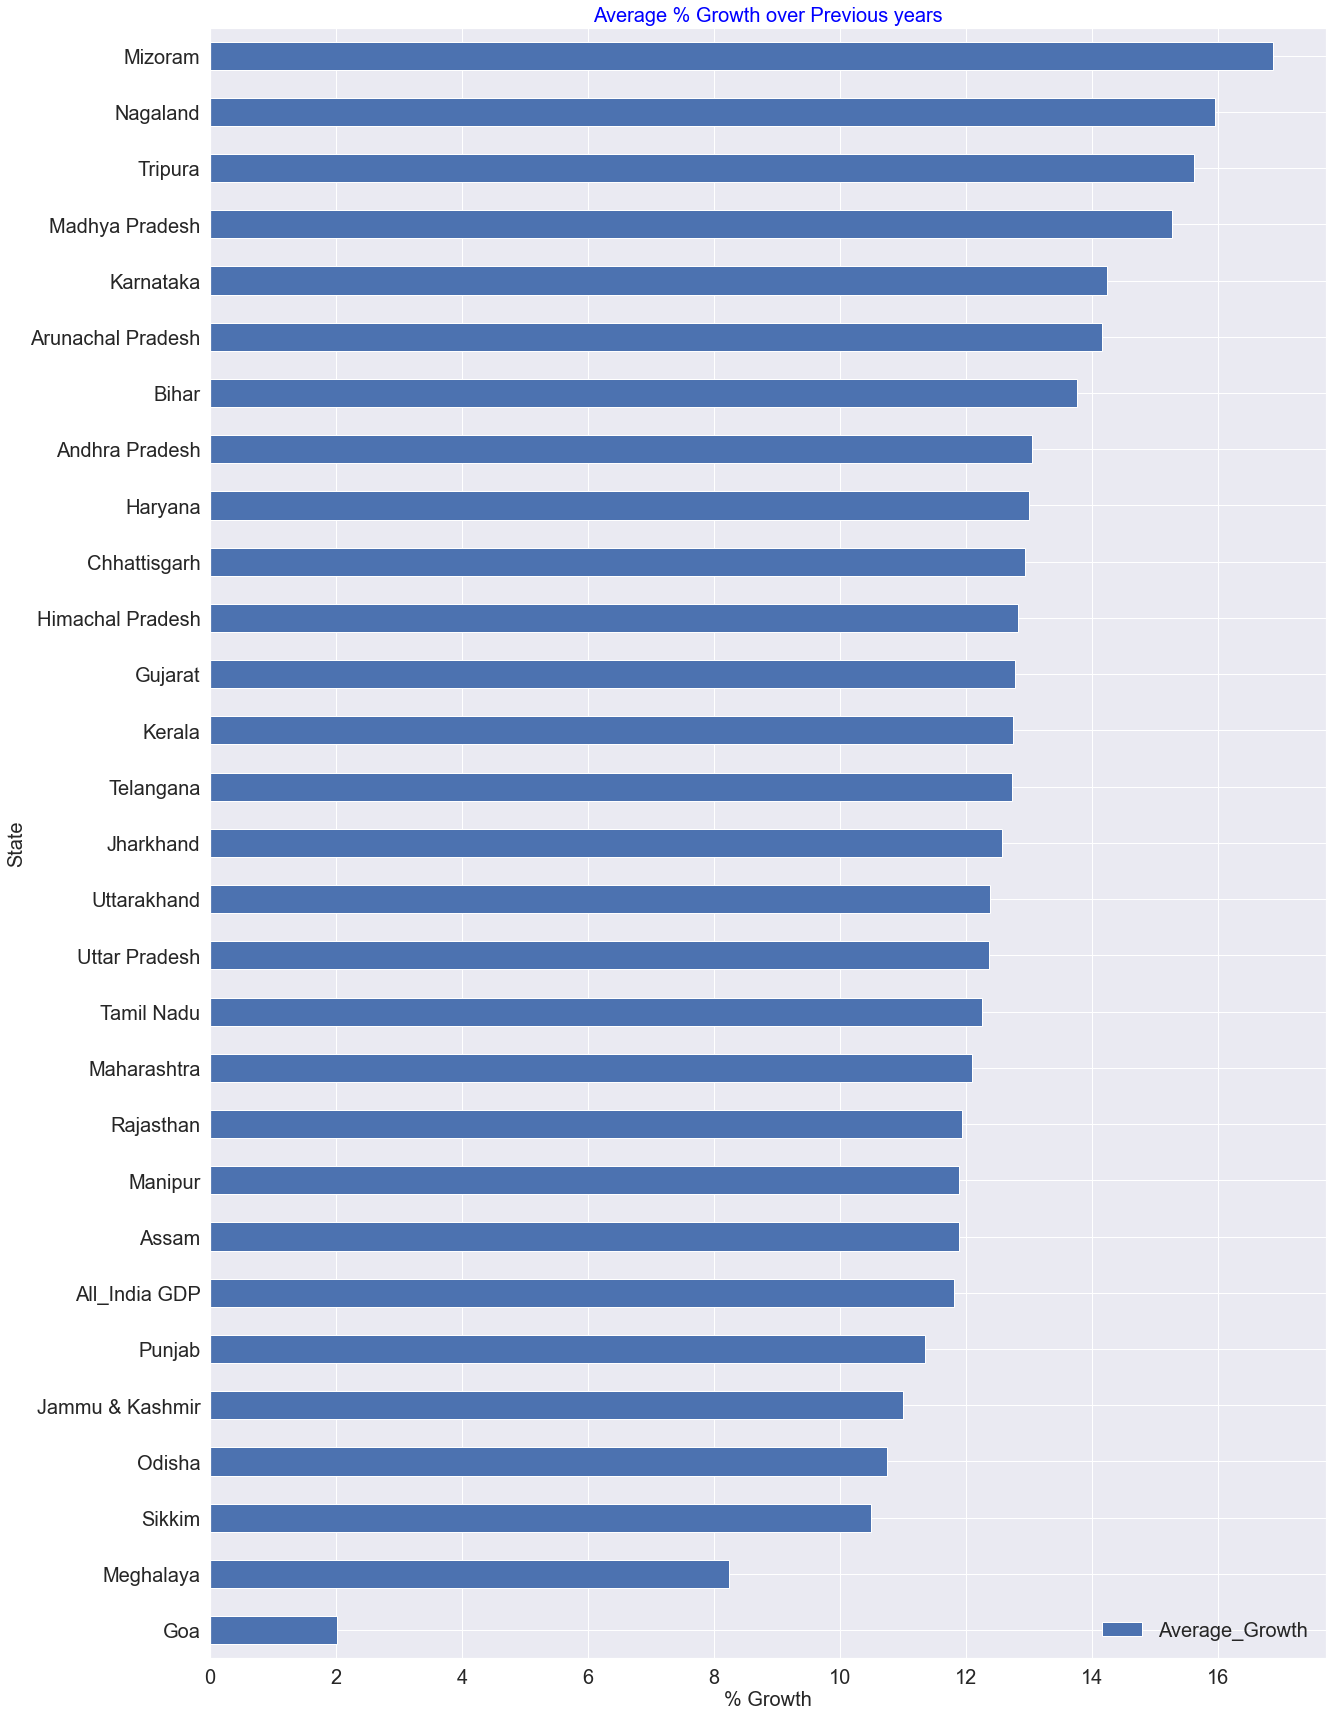

In [152]:
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
growth_transpose_df['Average_Growth'].sort_values(ascending=True).plot(kind='barh', figsize=(20,30))
plt.title('Average % Growth over Previous years',color='blue')
plt.ylabel('State')
plt.xlabel('% Growth')
plt.legend()

## Observation from the above figure
- The States of Punjab, Jammu and Kashmir, Odisha, Sikkim, Meghalaya and Goa have GDP growth percentage lower than national GDP growth percentage (2012 - 17)



# Part II - Finding the leading contributors to the state GDP

In [153]:
states_datacheck

,Andhra Pradesh,Arunachal Pradesh,Assam,Bihar,Chandigarh,Chattisgarh,Delhi,Goa,Gujarat,Haryana,...,Nagaland,Odisha,Punjab,Rajasthan,Sikkim,Tamil Nadu,Telenghana,Tripura,Uttarakhand,Uttar Pradesh
Missingness,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Duplicates,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Observation from the above dataset
- We can find Total GDP for each state using the following formula
    - Total GSVA = (Primary + Secondary + Tertiary) contributions
    - GSDP = Total GSVA + Taxes on Products - Subsidies on Products
- There are Union Territories present in the above dataset that need to be removed

<AxesSubplot:title={'center':'GDP per Capita for all States for the years 2014-15'}, xlabel='per Capita State GDP', ylabel='State'>

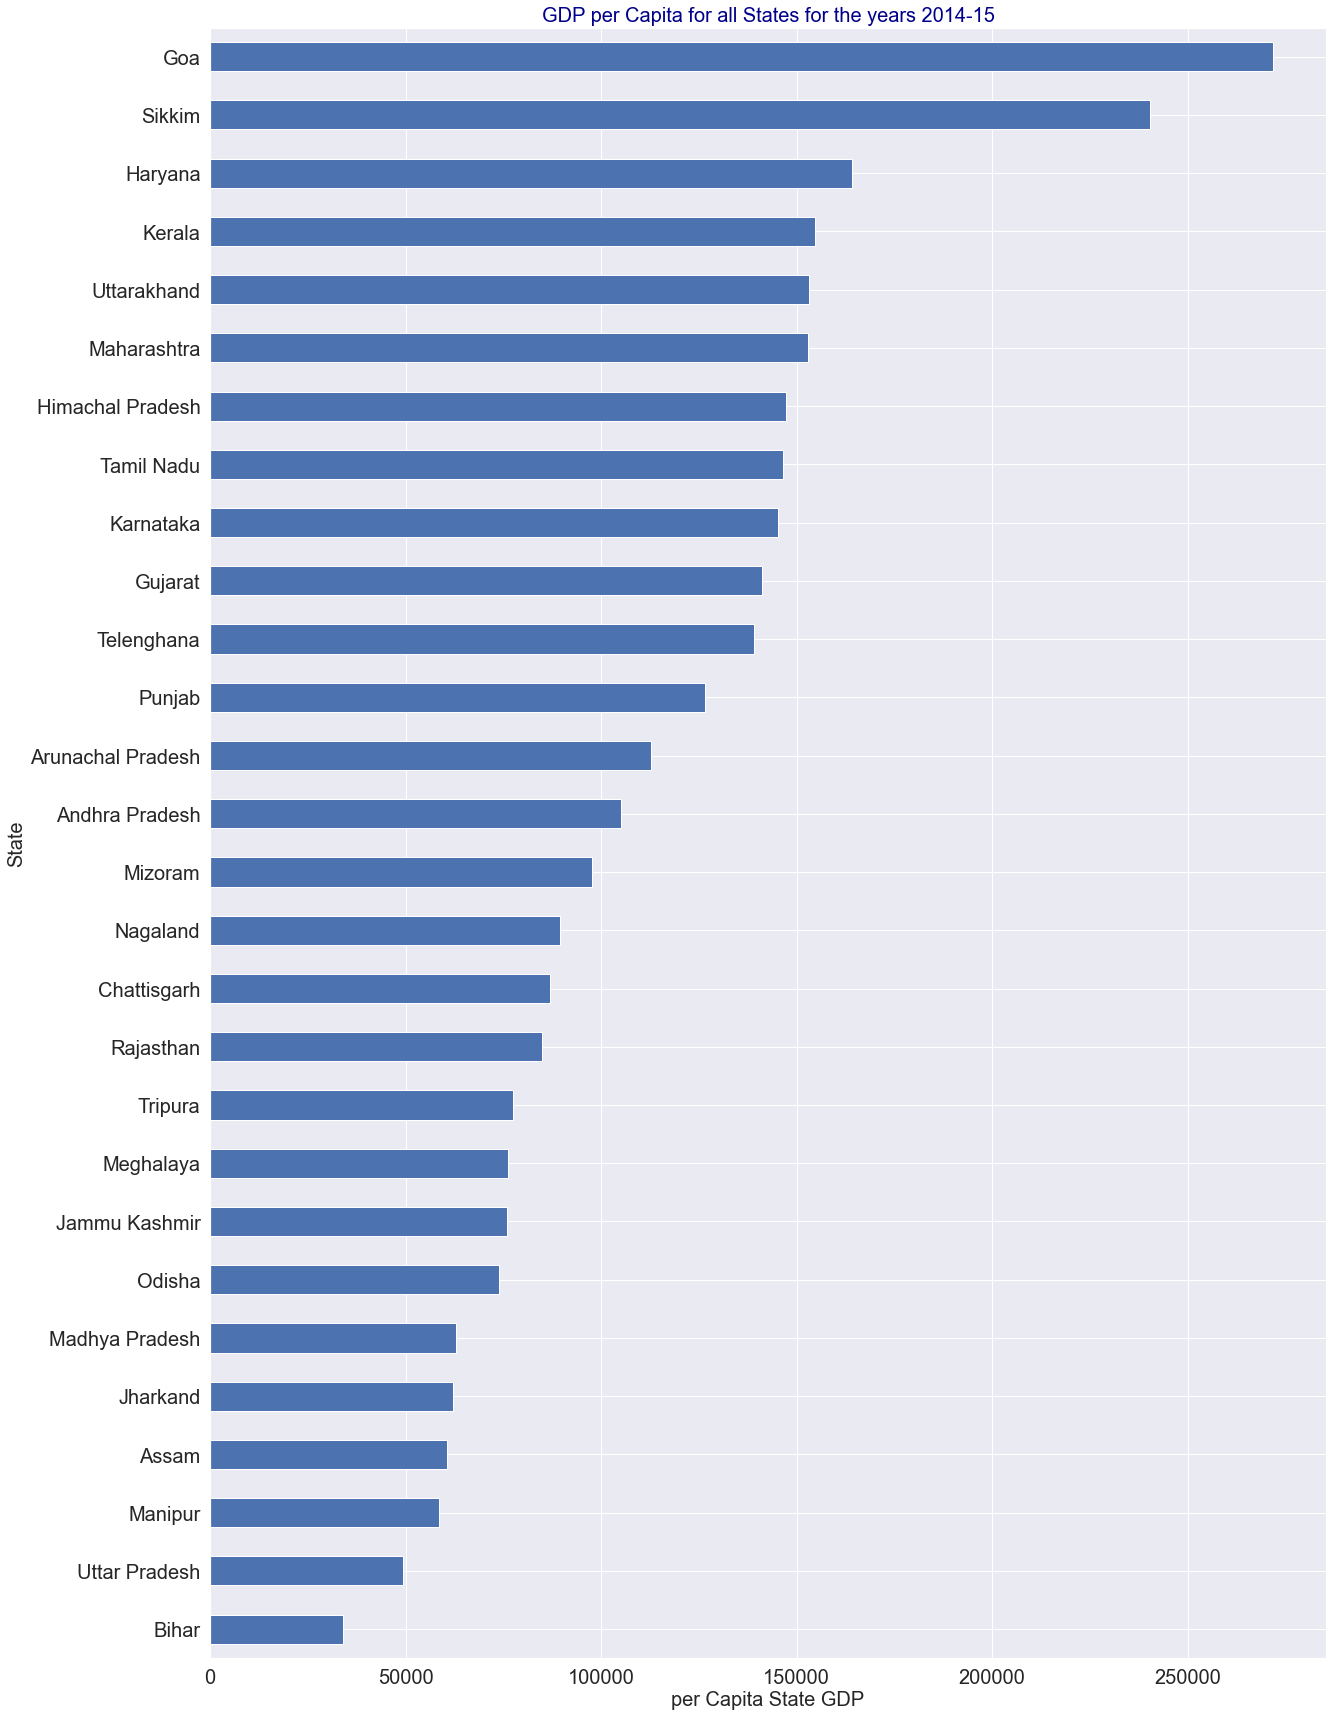

In [154]:
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.title('GDP per Capita for all States for the years 2014-15',color='darkblue')
plt.xlabel('per Capita State GDP')
plt.ylabel('State')
all_states_df.set_index('State')['Per Capita GSDP (Rs.)'].sort_values().plot(kind='barh',figsize=(20,30))

## Adding additional values to the dataset
- Percentage of Primary sectors on GSDP
- Percentage of Secondary sectors on GSDP 
- Percentage of Tertiary sectors on GSDP 
- Percentage of Taxes on the GSDP
- Percentage of Subsidies on GSDP

In [155]:

sort_gsdp_df = all_states_df.sort_values(by='Gross State Domestic Product',ascending=True)
sort_gsdp_df

Item,State,"Agriculture, forestry and fishing",Mining and quarrying,Primary,Manufacturing,"Electricity, gas, water supply & other utility services",Construction,Secondary,"Trade, repair, hotels and restaurants","Transport, storage, communication & services related to broadcasting",...,Gross State Domestic Product,Population ('00),Per Capita GSDP (Rs.),Primary_Perc,Secondary_Perc,Tertiary_Perc,Taxes_Perc,Subsidies_Perc,AllSectors_Perc,Percentile_Rank
19,Mizoram,217010,8588,225598,8479,128365,133228,270072,114315,52587,...,1155933,11833,97687,19.52,23.36,55.16,3.73,1.77,98.04,0.04
24,Sikkim,137447,1329,138776,550697,212499,82058,845253,70568,47347,...,1520933,6330,240274,9.12,55.57,31.76,4.75,1.21,96.45,0.07
1,Arunachal Pradesh,686117,30842,716959,26120,113527,147842,287489,60421,35203,...,1676119,14870,112718,42.77,17.15,37.70,4.18,1.81,97.62,0.11
17,Manipur,383140.0,NaN,383140.0,49501.0,27490.0,143182.0,220173.0,262950.0,109726.0,...,1804276.0,30873.0,58442.0,21.24,12.20,65.25,5.14,3.83,98.69,0.14
20,Nagaland,607897,8280,616178,18346,37944,156072,212361,140781,77521,...,1841424,20550,89607,33.46,11.53,53.92,3.13,2.05,98.91,0.18
18,Meghalaya,366521.0,84529.0,451050.0,433213.0,54473.0,150256.0,637942.0,383974.0,148189.0,...,2440807.0,32020.0,76228.0,18.48,26.14,49.19,8.74,2.54,93.81,0.21
27,Tripura,799825.0,142391.0,942216.0,228625.0,77870.0,177899.0,484393.0,390423.0,155956.0,...,2966662.0,38350.0,77358.0,31.76,16.33,50.05,5.03,3.17,98.14,0.25
7,Goa,308507,3622,312129,1177608,204110,165819,1547536,380927,189656,...,4063307,14950,271793,7.68,38.09,42.78,12.98,1.52,88.55,0.29
11,Jammu Kashmir,1586705,33621,1620326,893207,597421,785503,2276132,889931,712552,...,10040446,132390,75840,16.14,22.67,55.91,7.61,2.33,94.72,0.32
10,Himachal Pradesh,1514981,33385,1548366,2543637,767268,808256,4119162,615496,552234,...,10436879,70840,147330,14.84,39.47,39.60,8.58,2.48,93.91,0.36


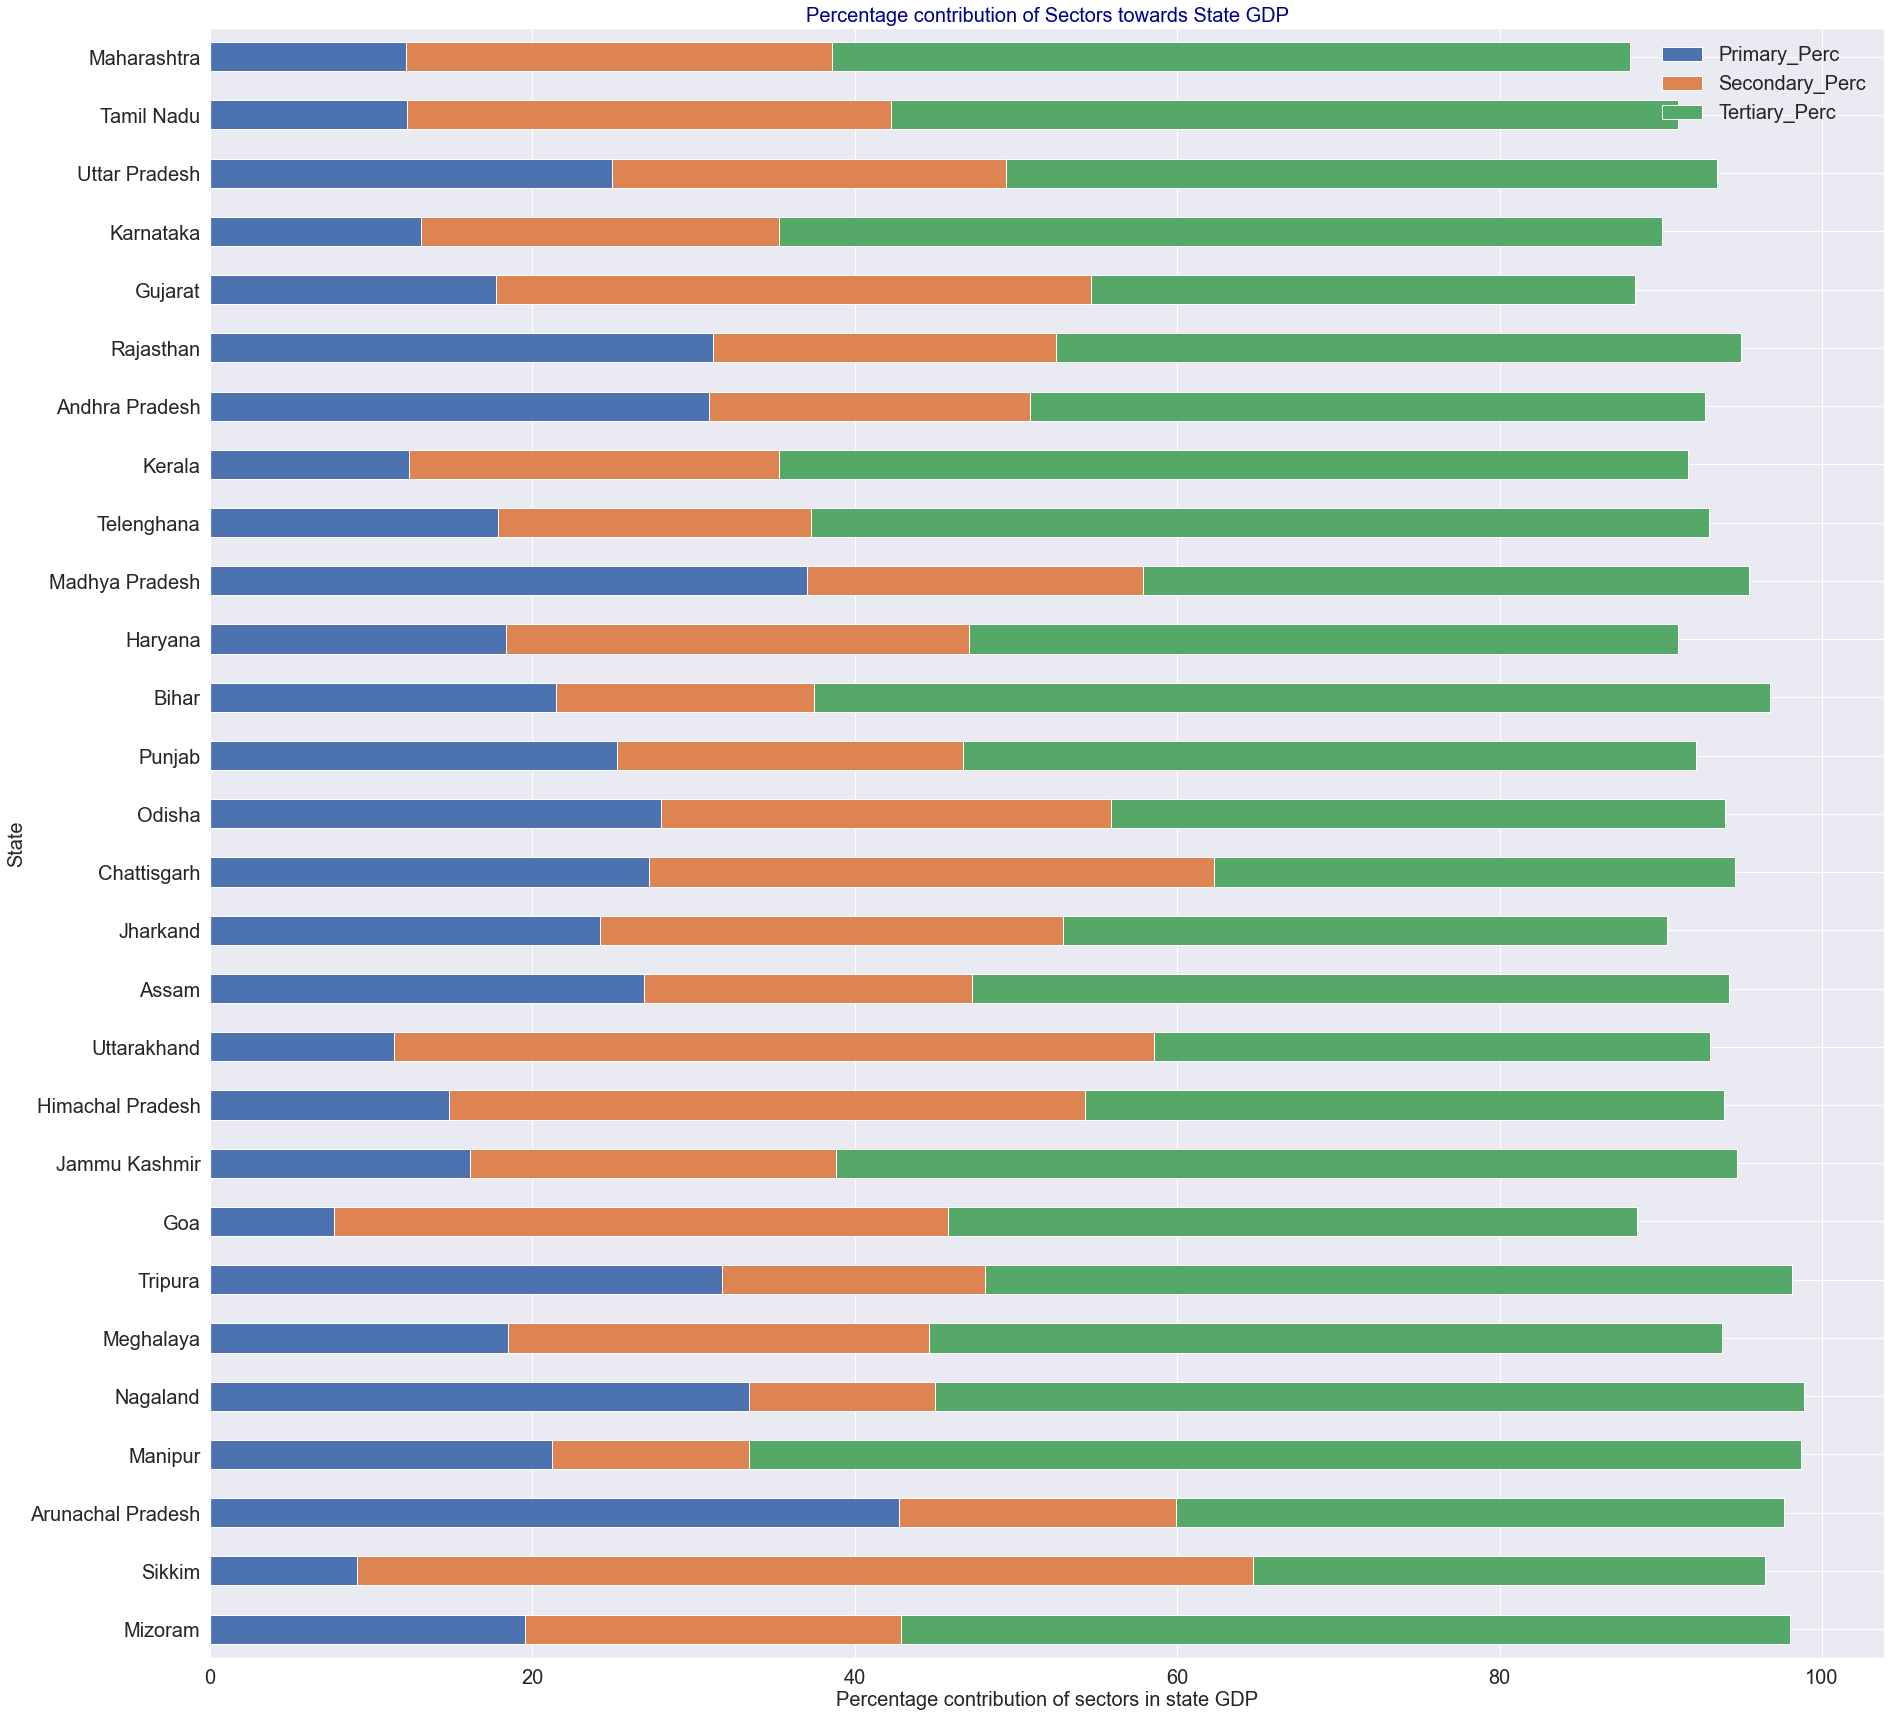

In [156]:
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
sort_gsdp_df[['State','Primary_Perc','Secondary_Perc','Tertiary_Perc']].set_index('State').plot(kind='barh',stacked=True,figsize=(30,30));
plt.title('Percentage contribution of Sectors towards State GDP',color='darkblue')
plt.xlabel('Percentage contribution of sectors in state GDP')
plt.ylabel('State')
plt.legend()

# Part III - Impact of education drop out rate on GSDP

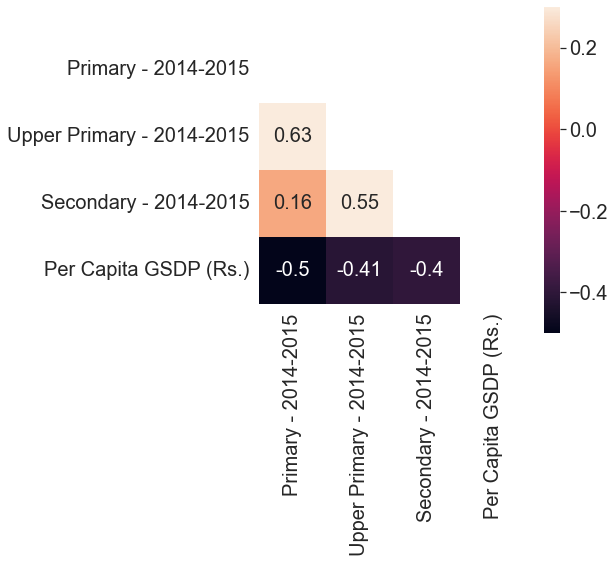

In [157]:
gdp_droput_df = state_dropout_df.copy()
# drop unnecessary columns from dataframe
gdp_droput_df = gdp_droput_df[['Primary - 2014-2015','Upper Primary - 2014-2015','Secondary - 2014-2015','Per Capita GSDP (Rs.)']]
numeric_cols = [col for col in gdp_droput_df]
gdp_droput_df[numeric_cols] = gdp_droput_df[numeric_cols].apply(pd.to_numeric, errors='coerce', axis=1)

plt.figure(figsize=(6,6))
mask = np.zeros_like(gdp_droput_df.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
      sns.heatmap(gdp_droput_df.corr(),mask=mask,vmax=.3, square=True, annot=True,)

In [158]:
def sector_dropout_heatmap(sector_droput_df,education_levels):
    sns.set(font_scale=1)
    nrows = int(np.ceil(len(education_levels)))

    fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(5,5*len(education_levels)), sharex=False, sharey=False)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    
    for i, edu_level in enumerate(education_levels):
        plt.subplots_adjust(hspace = 1.2)
        # drop unnecessary columns from dataframe
        subset_df = sector_droput_df.copy()
        subset_df = subset_df[['Primary_Perc','Secondary_Perc','Tertiary_Perc',edu_level]]
        numeric_cols = [col for col in subset_df]
        subset_df[numeric_cols] = subset_df[numeric_cols].apply(pd.to_numeric, errors='coerce', axis=1)

        mask = np.zeros_like(subset_df.corr())
        mask[np.triu_indices_from(mask)] = True
        with sns.axes_style("white"):
              sns.heatmap(round(subset_df.corr(),2),mask=mask,vmax=.3, square=True, annot=True,ax=ax[i])
              
        ax[i].set_title("Correlation of {0} dropout rate with Sectors".format(edu_level),color='blue')

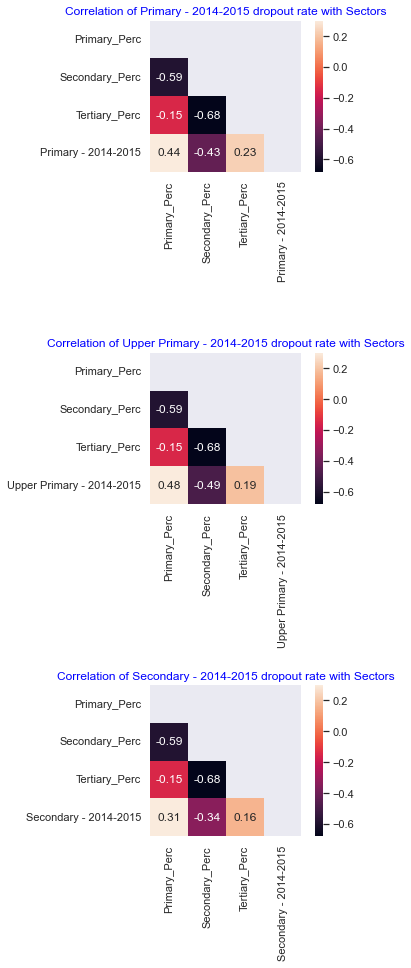

In [159]:
education_levels = ['Primary - 2014-2015','Upper Primary - 2014-2015','Secondary - 2014-2015']
sector_dropout_heatmap(state_dropout_df,education_levels)

# Observations from above plot
- Dropout rate of Primary education level is negative correlated with Secondary Sector %contribution. GDP of such states will decrease given the skilled and educated labor required for secondary sector is not easily available and thus doesn’t encourage industries to be setup. However there is positive correlation with Primary Sector %contribution. Given primary sectors rely on unskilled labor, a drop in primary schools creates a large labor pool helping primary sector and thus contribution to GDP growth.
- Dropout rate of Upper Primary education level is negative correlated with Secondary Sector %contribution. There is also a small negative correlation with Tertiary Sector %Contribution. This means with increase in dropout rate in Upper Primary education level, States with major contribution from Secondary Sectors will get affected. GDP of such states will decrease. However there is positive correlation with Primary Sector %contribution as per reason explained above.
- Dropout rate of Upper Secondary education level is negative correlated with Secondary Sector %contribution. This means with increase in dropout rate in Secondary education level, States with major contribution from Secondary Sectors will get affected. GDP of such states will decrease. However there is positive correlation with Primary Sector %contribution. This means with increase in dropout rate in Secondary education level, States with major contribution from Primary Sectors will see increase in GDP

# Hypothesis from above data of dropout rate and Sector's %contribution and population
- Increase in dropout rate negatively affects Secondary sector and thereby GDP of states with major %contribution from secondary sector
- Government must bring in measures to control dropout rate which will help in increase in GDP of states

In [160]:
state_dropout_df.columns

Index(['State', 'Agriculture, forestry and fishing', 'Mining and quarrying',
       'Primary', 'Manufacturing',
       'Electricity, gas, water supply & other utility services',
       'Construction', 'Secondary', 'Trade, repair, hotels and restaurants',
       'Transport, storage, communication & services related to broadcasting',
       'Financial services',
       'Real estate, ownership of dwelling & professional services',
       'Public administration', 'Other services', 'Tertiary',
       'TOTAL GSVA at basic prices', 'Taxes on Products',
       'Subsidies on products', 'Gross State Domestic Product',
       'Population ('00)', 'Per Capita GSDP (Rs.)', 'Primary_Perc',
       'Secondary_Perc', 'Tertiary_Perc', 'Taxes_Perc', 'Subsidies_Perc',
       'AllSectors_Perc', 'Percentile_Rank', 'Category', 'Primary - 2014-2015',
       'Upper Primary - 2014-2015', 'Secondary - 2014-2015'],
      dtype='object')

In [161]:
# Pearson's Correlation test
from scipy.stats import pearsonr
GDP_parameters = ['Primary', 'Secondary', 'Tertiary', 'Gross State Domestic Product', 'Per Capita GSDP (Rs.)', 'Primary_Perc', 'Secondary_Perc', 'Tertiary_Perc']
# GDP_parameters = ['Per Capita GSDP (Rs.)']

Education_parameters = ['Primary - 2014-2015', 'Upper Primary - 2014-2015', 'Secondary - 2014-2015']
temp = []
for g in GDP_parameters:
    for e in Education_parameters:
        temp_df = state_dropout_df[[g, e]]
        temp_df.dropna(inplace=True)
        x1 = temp_df[g].values
        x2 = temp_df[e].values
        stat, p = pearsonr(x1, x2)
        # print()
        if p > 0.05:
            pass
            # print(g, e, "Independent")
        else:
            print("GDP Paramter:", g, "\tEducation Paramter:", e, "Dependent p-value", p)
            temp.append([g, e])

GDP Paramter: Per Capita GSDP (Rs.) 	Education Paramter: Primary - 2014-2015 Dependent p-value 0.010903736298339248
GDP Paramter: Per Capita GSDP (Rs.) 	Education Paramter: Upper Primary - 2014-2015 Dependent p-value 0.035735683291746034
GDP Paramter: Per Capita GSDP (Rs.) 	Education Paramter: Secondary - 2014-2015 Dependent p-value 0.035506889398405204
GDP Paramter: Primary_Perc 	Education Paramter: Primary - 2014-2015 Dependent p-value 0.026329484710711074
GDP Paramter: Primary_Perc 	Education Paramter: Upper Primary - 2014-2015 Dependent p-value 0.014150003267471142
GDP Paramter: Secondary_Perc 	Education Paramter: Primary - 2014-2015 Dependent p-value 0.03174507251728866
GDP Paramter: Secondary_Perc 	Education Paramter: Upper Primary - 2014-2015 Dependent p-value 0.011224479099451085


In [162]:
# Spearman's Rank Correlation Test
from scipy.stats import spearmanr
for g in GDP_parameters:
    for e in Education_parameters:
        temp_df = state_dropout_df[[g, e]]
        temp_df.dropna(inplace=True)
        x1 = temp_df[g].values
        x2 = temp_df[e].values
        stat, p = spearmanr(x1, x2)
        if p > 0.05:
            pass
            # print(g, e, "Independent")
        else:
            print("GDP Paramter:", g, "\tEducation Paramter:", e, "Dependent")

GDP Paramter: Per Capita GSDP (Rs.) 	Education Paramter: Primary - 2014-2015 Dependent
GDP Paramter: Per Capita GSDP (Rs.) 	Education Paramter: Secondary - 2014-2015 Dependent
GDP Paramter: Primary_Perc 	Education Paramter: Primary - 2014-2015 Dependent
GDP Paramter: Primary_Perc 	Education Paramter: Upper Primary - 2014-2015 Dependent
GDP Paramter: Secondary_Perc 	Education Paramter: Primary - 2014-2015 Dependent
GDP Paramter: Secondary_Perc 	Education Paramter: Upper Primary - 2014-2015 Dependent
GDP Paramter: Secondary_Perc 	Education Paramter: Secondary - 2014-2015 Dependent


In [163]:
# Kendall's Rank Correlation Test
from scipy.stats import kendalltau
for g in GDP_parameters:
    for e in Education_parameters:
        temp_df = state_dropout_df[[g, e]]
        temp_df.dropna(inplace=True)
        x1 = temp_df[g].values
        x2 = temp_df[e].values
        stat, p = kendalltau(x1, x2)
        if p > 0.05:
            pass
            # print(g, e, "Independent")
        else:
            print("GDP Paramter:", g, "\tEducation Paramter:", e, "Dependent")

GDP Paramter: Per Capita GSDP (Rs.) 	Education Paramter: Primary - 2014-2015 Dependent
GDP Paramter: Per Capita GSDP (Rs.) 	Education Paramter: Secondary - 2014-2015 Dependent
GDP Paramter: Primary_Perc 	Education Paramter: Primary - 2014-2015 Dependent
GDP Paramter: Primary_Perc 	Education Paramter: Upper Primary - 2014-2015 Dependent
GDP Paramter: Secondary_Perc 	Education Paramter: Primary - 2014-2015 Dependent
GDP Paramter: Secondary_Perc 	Education Paramter: Upper Primary - 2014-2015 Dependent
GDP Paramter: Secondary_Perc 	Education Paramter: Secondary - 2014-2015 Dependent


# From the above cella of code we can summarise the following dependencies in our dataset.

    - The GDP per capita of each state is affected by the education dropout rate in Primary, Upper Primary and Secondary levels.

    - The Primary percentage(Primary sector GDP/ Total GDP) is affected by the education dropout rate in Primary, Upper Primary and Secondary levels.

    - The Secondary percentage(Secondary sector GDP/ Total GDP) is affected by the education dropout rate in Primary and Upper Primary levels.

# Machine Learning Models

## Regression Models

In [164]:
gdp

[['Andhra Pradesh', [array([ 83001,  93121, 104977], dtype=int64)]],
 ['Arunachal Pradesh', [array([ 87862, 100220, 112718], dtype=int64)]],
 ['Assam', [array([49254, 55098, 60621], dtype=int64)]],
 ['Bihar', [array([26459, 29251, 33954], dtype=int64)]],
 ['Chandigarh', [array([200080, 226161, 250398], dtype=int64)]],
 ['Chattisgarh', [array([67750, 77633, 86860], dtype=int64)]],
 ['Delhi', [array([226149, 251706, 274041], dtype=int64)]],
 ['Goa', [array([258441, 241893, 271793], dtype=int64)]],
 ['Gujarat', [array([117398., 129158., 141263.])]],
 ['Haryana', [array([133875., 152401., 164077.])]],
 ['Himachal Pradesh', [array([118960, 134934, 147330], dtype=int64)]],
 ['Jammu Kashmir', [array([67812, 73532, 75840], dtype=int64)]],
 ['Jharkand', [array([51620., 54813., 62091.])]],
 ['Karnataka', [array([111294, 130181, 145141], dtype=int64)]],
 ['Kerala', [array([122471, 137515, 154778], dtype=int64)]],
 ['Madhya Pradesh', [array([51253, 58046, 62989], dtype=int64)]],
 ['Maharashtra', [

In [165]:
education.rename(columns={'Level of Education - State':'State'},inplace=True)
education.fillna(education.median(), inplace=True)
education

,State,Primary - 2012-2013,Primary - 2013-2014,Primary - 2014-2015
1,Andhra Pradesh,3.18,4.350,6.720
2,Arunachal Pradesh,15.16,10.890,10.820
3,Assam,6.24,7.440,15.360
4,Bihar,4.14,2.090,4.575
6,Chhatisgarh,4.14,1.420,2.910
10,Goa,4.14,0.200,0.730
11,Gujarat,0.74,0.760,0.890
12,Haryana,1.29,0.410,5.610
13,Himachal Pradesh,0.45,0.460,0.640
14,Jammu and Kashmir,6.30,5.460,6.790


In [166]:
data = []
for state, GDPvals in gdp:
    for _state in education["State"].values:
        if state == _state:
            # print(state)
            data.append([GDPvals[0][0], education.loc[education["State"] == _state, "Primary - 2012-2013"]])
            data.append([GDPvals[0][1], education.loc[education["State"] == _state, "Primary - 2013-2014"]])
            data.append([GDPvals[0][2], education.loc[education["State"] == _state, "Primary - 2014-2015"]])

data

[[83001,
  1    3.18
  Name: Primary - 2012-2013, dtype: float64],
 [93121,
  1    4.35
  Name: Primary - 2013-2014, dtype: float64],
 [104977,
  1    6.72
  Name: Primary - 2014-2015, dtype: float64],
 [87862,
  2    15.16
  Name: Primary - 2012-2013, dtype: float64],
 [100220,
  2    10.89
  Name: Primary - 2013-2014, dtype: float64],
 [112718,
  2    10.82
  Name: Primary - 2014-2015, dtype: float64],
 [49254,
  3    6.24
  Name: Primary - 2012-2013, dtype: float64],
 [55098,
  3    7.44
  Name: Primary - 2013-2014, dtype: float64],
 [60621,
  3    15.36
  Name: Primary - 2014-2015, dtype: float64],
 [26459,
  4    4.14
  Name: Primary - 2012-2013, dtype: float64],
 [29251,
  4    2.09
  Name: Primary - 2013-2014, dtype: float64],
 [33954,
  4    4.575
  Name: Primary - 2014-2015, dtype: float64],
 [258441,
  10    4.14
  Name: Primary - 2012-2013, dtype: float64],
 [241893,
  10    0.2
  Name: Primary - 2013-2014, dtype: float64],
 [271793,
  10    0.73
  Name: Primary - 2014-2015,

In [167]:
df = pd.DataFrame(data=data)
df.columns = ["GSDP per capita", "Dropout Rate"]
educationTemp = [] 
for val in df["Dropout Rate"].values:
    educationTemp.append(list(val)[0])

df["Dropout Rate"] = educationTemp

df

,GSDP per capita,Dropout Rate
0,83001.0,3.18
1,93121.0,4.35
2,104977.0,6.72
3,87862.0,15.16
4,100220.0,10.89
...,...,...
64,67545.0,3.58
65,77358.0,1.28
66,40205.0,10.28
67,45433.0,7.08


Slope:  -2.4999015127473814
Intercept:  46.94518801987315
The linear model is: Y = 46.945 + -2.4999X
GSDP per capita Dropout Rate
Root Mean Squared Error =  3.6760532626171147


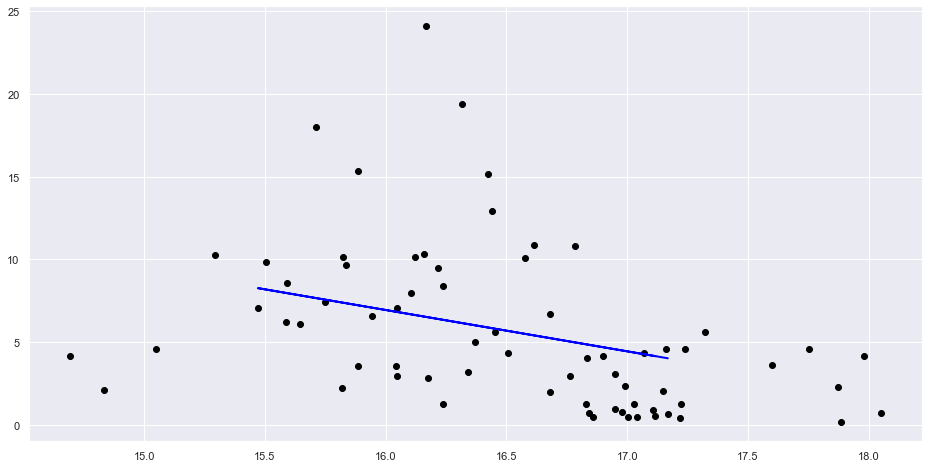

In [169]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import math

g, e = "GSDP per capita","Dropout Rate"
Tdf = df.copy()
Tdf[g] = np.log2(Tdf[g])

x = Tdf[g].values.reshape(-1,1)
y = Tdf[e].values.reshape(-1,1)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.1)
reg = LinearRegression()
reg.fit(x_train, y_train)

print("Slope: ",reg.coef_[0][0])
print("Intercept: ",reg.intercept_[0])
print("The linear model is: Y = {:.5} + {:.5}X".format(reg.intercept_[0], reg.coef_[0][0]))

print(g, e)
predictions = reg.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test,predictions))
print("Root Mean Squared Error = ",rmse)


plt.figure(figsize=(16, 8))
plt.scatter(
x,
y,
c='black'
)
plt.plot(
x_test,
predictions,
c='blue',
linewidth=2
)
plt.show()


In [170]:
state_dropout_df.head()

,State,"Agriculture, forestry and fishing",Mining and quarrying,Primary,Manufacturing,"Electricity, gas, water supply & other utility services",Construction,Secondary,"Trade, repair, hotels and restaurants","Transport, storage, communication & services related to broadcasting",...,Secondary_Perc,Tertiary_Perc,Taxes_Perc,Subsidies_Perc,AllSectors_Perc,Percentile_Rank,Category,Primary - 2014-2015,Upper Primary - 2014-2015,Secondary - 2014-2015
0,Andhra Pradesh,14819416,1484300,16303716,4672266,1151729,4664889,10488884,4233400,5076984,...,19.92,41.85,10.47,3.21,92.74,0.79,C2,6.72,5.20,15.71
1,Arunachal Pradesh,686117,30842,716959,26120,113527,147842,287489,60421,35203,...,17.15,37.70,4.18,1.81,97.62,0.11,C2,10.82,6.71,17.11
2,Assam,3855548,1471149,5326697,2002936,296587,1733568,4033091,2987155,1194568,...,20.36,46.98,8.71,2.94,94.23,0.43,C4,15.36,10.51,27.06
3,Bihar,7951890,68107,8019997,2189965,345168,3449763,5984896,7448373,3147173,...,16.01,59.32,8.59,5.37,96.78,0.61,C4,NaN,4.08,25.90
4,Chattisgarh,3948847,2451970,6400817,4370593,1198438,2669855,8238886,1535571,871770,...,35.06,32.30,11.07,5.67,94.60,0.50,C3,6.79,5.44,17.28


In [171]:
state_dropout_df.columns

Index(['State', 'Agriculture, forestry and fishing', 'Mining and quarrying',
       'Primary', 'Manufacturing',
       'Electricity, gas, water supply & other utility services',
       'Construction', 'Secondary', 'Trade, repair, hotels and restaurants',
       'Transport, storage, communication & services related to broadcasting',
       'Financial services',
       'Real estate, ownership of dwelling & professional services',
       'Public administration', 'Other services', 'Tertiary',
       'TOTAL GSVA at basic prices', 'Taxes on Products',
       'Subsidies on products', 'Gross State Domestic Product',
       'Population ('00)', 'Per Capita GSDP (Rs.)', 'Primary_Perc',
       'Secondary_Perc', 'Tertiary_Perc', 'Taxes_Perc', 'Subsidies_Perc',
       'AllSectors_Perc', 'Percentile_Rank', 'Category', 'Primary - 2014-2015',
       'Upper Primary - 2014-2015', 'Secondary - 2014-2015'],
      dtype='object')

In [181]:
KM_df = state_dropout_df[["State",'Per Capita GSDP (Rs.)', 'Primary - 2014-2015']].copy()
KM_df.fillna(KM_df.median(), inplace=True)
KM_df.set_index("State", inplace=True)
KM_df

,Per Capita GSDP (Rs.),Primary - 2014-2015
State,,
Andhra Pradesh,104977.0,6.72
Arunachal Pradesh,112718.0,10.82
Assam,60621.0,15.36
Bihar,33954.0,5.02
Chattisgarh,86860.0,6.79
Goa,271793.0,0.73
Gujarat,141263.0,0.89
Haryana,164077.0,5.61
Himachal Pradesh,147330.0,0.64


[[7.29946667e+04 6.53600000e+00]
 [1.43943636e+05 3.98636364e+00]
 [2.56033500e+05 1.50000000e+00]]
[0 1 0 0 0 2 1 1 1 0 0 1 1 0 1 0 0 0 0 0 1 0 2 1 1 0 1 0]


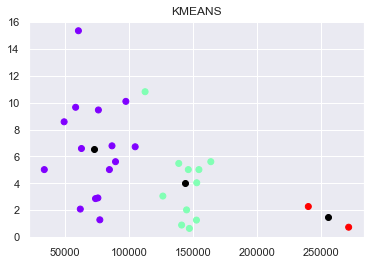

In [182]:
from sklearn.cluster import KMeans 

kmeans = KMeans(n_clusters=3
)
kmeans.fit(KM_df)

print(kmeans.cluster_centers_) 
print(kmeans.labels_)
KM_df["Cluster"] = (kmeans.labels_)
plt.title('KMEANS')
plt.scatter(KM_df["Per Capita GSDP (Rs.)"], KM_df["Primary - 2014-2015"], c=kmeans.labels_, cmap='rainbow') 
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')
plt.show()

In [183]:
KM_df.sort_values("Cluster")

,Per Capita GSDP (Rs.),Primary - 2014-2015,Cluster
State,,,
Andhra Pradesh,104977.0,6.72,0
Tripura,77358.0,1.28,0
Rajasthan,84837.0,5.02,0
Odisha,73979.0,2.86,0
Nagaland,89607.0,5.61,0
Mizoram,97687.0,10.10,0
Meghalaya,76228.0,9.46,0
Manipur,58442.0,9.66,0
Jharkand,62091.0,2.08,0
